# Gradient boosting
In this model generation, I explore gradient boosting

In addition, the component ids are decomposed by Jingyi into component types 
and the related info.

In [2]:
%matplotlib inline
import os, glob
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from IPython.display import display
#from pyearth import Earth

In [3]:
train = pd.read_csv(os.path.join('..','competition_data','train2.csv'),header=0,index_col=1)

In [33]:
train.columns

Index([u'Unnamed: 0', u'tube_assembly_id', u'supplier', u'bracket_pricing',
       u'quantity', u'cost', u'component_id_1_name', u'quantity_1',
       u'component_id_2_name', u'quantity_2', u'component_id_3_name',
       u'quantity_3', u'material_id', u'diameter', u'wall', u'length',
       u'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x', u'end_a',
       u'end_x', u'year', u'month', u'day'],
      dtype='object')

In [34]:
train[0:1]

,Unnamed: 0,tube_assembly_id,supplier,bracket_pricing,quantity,cost,component_id_1_name,quantity_1,component_id_2_name,quantity_2,...,length,num_bends,bend_radius,end_a_2x,end_x_2x,end_a,end_x,year,month,day
0,0,TA-00002,S-0066,Yes,1,21.905933,NUT-FLARED,2,NaN,0,...,137,8,19.05,N,N,EF-008,EF-008,2013,7,919


In the predictor data, the first two columns are unnecessary.

In [4]:
trainp = train.loc[:,['quantity', 
                      'component_id_1_name','quantity_1',
                      'component_id_2_name','quantity_2',
                      'component_id_3_name','quantity_3',
                      'material_id','diameter','wall','length',
                      'num_bends','bend_radius','end_a_2x',
                      'end_x_2x','end_a','end_x','year',
                      'month','day','cost']]

## Categorical variables pruning
The categorical variables such as material_id, component_id_x_name, 
end_x, end_a with string categories are converted to integer
labels. The values with high frequencies are retained and the low
frequency values (<100) are all combined into a single value

In [41]:
print trainp.component_id_1_name.value_counts()[0:16]
print trainp.component_id_2_name.value_counts()[0:9]
print trainp.component_id_3_name.value_counts()[0:5]

NUT-SWIVEL         9364
NUT-FLARED         4774
CONNECTOR-SEAL     1131
NUT                1130
NUT-INV FLARED      758
SLEEVE-ORFS         174
CONNECTOR           159
FLANGE              135
HEAD-FLANGED         96
BOSS                 93
ELBOW                85
SLEEVE               85
SLEEVE-FITTING       79
FLANGE-ONE PIEC      66
ELBOW-90 DEG         62
ELBOW-FLARED         48
dtype: int64
SLEEVE-ORFS         8873
SLEEVE-FLARED        886
SLEEVE               860
NUT-SWIVEL           564
CONNECTOR-SEAL       322
ELBOW-90 DEG         149
SLEEVE-FACE SEAL     132
NUT                  109
NUT-FITTING           79
dtype: int64
CONNECTOR-SEAL    2727
SLEEVE-ORFS        445
ELBOW-90 DEG       271
CONNECTOR          144
SLEEVE-REDUCER      91
dtype: int64


In [37]:
print sum(trainp.component_id_1_name.isnull().values)
print sum(trainp.component_id_2_name.isnull().values)
print sum(trainp.component_id_3_name.isnull().values)

477
6321
14741


In [5]:
lbl_enc = LabelEncoder()
lbl_enc.fit(trainp.component_id_1_name.values)  
print lbl_enc.classes_
comp_id1_trans = lbl_enc.transform(trainp.component_id_1_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id1_trans:
    d[i] += 1
print d


for i in range(len(comp_id1_trans)):
    if d[comp_id1_trans[i]] < 135:
        comp_id1_trans[i] = 1 

d1 = defaultdict(int)
for i in comp_id1_trans:
    d1[i] += 1

print d1

lbl1_map = {}
for i, lbl in enumerate(list(lbl_enc.classes_)):
    lbl1_map[lbl] = i

[nan 'ADAPTER' 'ADAPTER-EXH PIP' 'ADAPTER-INLET' 'ADAPTER-O DRAIN'
 'ADAPTER-SUPPLY' 'BAR' 'BLOCK' 'BLOCK-DRAIN' 'BOSS' 'COLLAR' 'CONNECTOR'
 'CONNECTOR-FLARE' 'CONNECTOR-ORFS' 'CONNECTOR-SEAL' 'CONNECTOR-SPL'
 'CONNECTOR-WELD' 'COUPLET' 'COUPLET-WELD' 'COUPLING (1"BSP)' 'COUPLING AS'
 'ELBOW' 'ELBOW-90 DEG' 'ELBOW-90 DEGREE' 'ELBOW-FLARED' 'ELBOW-HYDRAULIC'
 'ELBOW-MANF IN' 'ELBOW-WATER' 'FITTING' 'FITTING-NUT' 'FLANGE'
 'FLANGE-ONE PIEC' 'FLANGE-ONE PIECE' 'FLANGE-SPL' 'HEAD-FLANGED' 'LINK'
 'MANIFOLD' 'NUT' 'NUT-45 (DEG)' 'NUT-A/C' 'NUT-FITTING' 'NUT-FLARED'
 'NUT-INV FLARED' 'NUT-SWIVEL' 'ORIFICE' 'PLATE' 'SEAL-O-RING' 'SLEEVE'
 'SLEEVE-FITTING' 'SLEEVE-ORFS' 'TEE-UNION' 'WASHER']
defaultdict(<type 'int'>, {0: 477, 1: 26, 2: 2, 3: 1, 4: 3, 5: 8, 6: 3, 7: 1, 8: 3, 9: 93, 10: 4, 11: 159, 12: 32, 13: 8, 14: 1131, 15: 8, 16: 40, 17: 3, 18: 6, 19: 4, 20: 13, 21: 85, 22: 62, 23: 8, 24: 48, 25: 16, 26: 2, 27: 1, 28: 43, 29: 8, 30: 135, 31: 66, 32: 4, 33: 8, 34: 96, 35: 1, 36: 8, 37: 1130,

/home/mbkumar/venv1/lib/python2.7/site-packages/numpy-1.9.2-py2.7-linux-x86_64.egg/numpy/lib/arraysetops.py:198: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/home/mbkumar/venv1/lib/python2.7/site-packages/numpy-1.9.2-py2.7-linux-x86_64.egg/numpy/lib/arraysetops.py:251: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


In [6]:
lbl_enc = LabelEncoder()
lbl_enc.fit(trainp.component_id_2_name.values)  
print lbl_enc.classes_
print trainp.component_id_2_name.value_counts()
print list(lbl_enc.classes_).index('SLEEVE-ORFS')
comp_id2_trans = lbl_enc.transform(trainp.component_id_2_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id2_trans:
    d[i] += 1
print d
for i in range(len(comp_id2_trans)):
    if d[comp_id2_trans[i]] < 109:
        comp_id2_trans[i] = 1 

d2 = defaultdict(int)
for i in comp_id2_trans:
    d2[i] += 1

print d2

lbl2_map = {}
for i, lbl in enumerate(list(lbl_enc.classes_)):
    lbl2_map[lbl] = i

[nan 'ADAPTER' 'ADAPTER-INLET' 'ADAPTER-O RING' 'BLOCK' 'BOSS'
 'BOSS-FITTING' 'CONNECTOR' 'CONNECTOR-BHD' 'CONNECTOR-FLARE'
 'CONNECTOR-O-RIN' 'CONNECTOR-ORFS' 'CONNECTOR-SEAL' 'CONNECTOR-SPL'
 'CONNECTOR-SWIVEL' 'CONNECTOR-WELD' 'ELBOW' 'ELBOW-90 DEG'
 'ELBOW-90 DEGREE' 'ELBOW-90 DEGREES' 'ELBOW-HYDRAULIC' 'FLANGE'
 'FLANGE-4 BOLT' 'FLANGE-CAPTIVE' 'FLANGE-ONE PIEC' 'FLANGE-SADDLE'
 'FLANGE-WELD' 'HEAD O-RING' 'HEAD-FLANGED' 'LINK' 'NUT' 'NUT-45 (DEG)'
 'NUT-A/C' 'NUT-FITTING' 'NUT-FLARED' 'NUT-SWIVEL' 'PIN-DOWEL' 'PLATE'
 'PLUG' 'PLUG-O-RING' 'REDUCER' 'SLEEEVE-REDUCER' 'SLEEVE'
 'SLEEVE-FACE SEAL' 'SLEEVE-FITTING' 'SLEEVE-FLARED' 'SLEEVE-ORFS'
 'SLEEVE-REDUCER' 'STUD-WELD' 'TEE-ORFS TO BRA' 'TUBE' 'TUBE AS']
SLEEVE-ORFS         8873
SLEEVE-FLARED        886
SLEEVE               860
NUT-SWIVEL           564
CONNECTOR-SEAL       322
ELBOW-90 DEG         149
SLEEVE-FACE SEAL     132
NUT                  109
NUT-FITTING           79
SLEEVE-REDUCER        72
CONNECTOR             72
CON

In [7]:
lbl_enc3 = LabelEncoder()
lbl_enc3.fit(trainp.component_id_3_name.values)  
print lbl_enc3.classes_
comp_id3_trans = lbl_enc3.transform(trainp.component_id_3_name.values)
from collections import defaultdict
d = defaultdict(int)
for i in comp_id3_trans:
    d[i] += 1
print d
for i in range(len(comp_id3_trans)):
    if d[comp_id3_trans[i]] < 100:
        comp_id3_trans[i] = 1 

d3 = defaultdict(int)
for i in comp_id3_trans:
    d3[i] += 1

print d3

lbl3_map = {}
for i, lbl in enumerate(list(lbl_enc3.classes_)):
    lbl3_map[lbl] = i

[nan 'ADAPTER' 'ADAPTER-O LINE' 'ADAPTER-O SUPPL' 'ADAPTER-OIL LIN' 'BLOCK'
 'BLOCK-HYD' 'BOSS' 'CONNECTOR' 'CONNECTOR-BHD' 'CONNECTOR-ORFS'
 'CONNECTOR-SEAL' 'CONNECTOR-SPL' 'CONNECTOR-WELD' 'ELBOW' 'ELBOW-37 (DEG)'
 'ELBOW-90 (DEG)' 'ELBOW-90 DEG' 'ELBOW-90 DEGREE' 'ELBOW-HYDRAULIC'
 'FITTING' 'FLANGE' 'FLANGE-ONE PC' 'FLANGE-ONE PIEC' 'FLANGE-ONE PIECE'
 'HEAD FLANGED' 'HEAD-FLANGED' 'NUT-ORFS' 'NUT-SWIVEL' 'PLATE' 'PLUG-STOR'
 'SLEEVE' 'SLEEVE-FLARED' 'SLEEVE-ORFS' 'SLEEVE-REDUCER' 'TEE-FLARED'
 'TUBE' 'TUBE AS.']
defaultdict(<type 'int'>, {0: 14741, 1: 8, 2: 8, 3: 8, 4: 7, 5: 47, 6: 8, 7: 40, 8: 144, 9: 71, 10: 72, 11: 2727, 12: 16, 13: 64, 14: 35, 15: 16, 16: 20, 17: 271, 18: 24, 19: 4, 20: 8, 21: 32, 22: 2, 23: 1, 24: 4, 25: 8, 26: 16, 27: 7, 28: 48, 29: 5, 30: 2, 31: 35, 32: 32, 33: 445, 34: 91, 35: 8, 36: 3, 37: 8})
defaultdict(<type 'int'>, {0: 14741, 33: 445, 1: 758, 8: 144, 11: 2727, 17: 271})


In [8]:
comp_id1_trans = np.expand_dims(comp_id1_trans,axis=1)
comp_id2_trans = np.expand_dims(comp_id2_trans,axis=1)
comp_id3_trans = np.expand_dims(comp_id3_trans,axis=1)
#enc_comp_id1 = OneHotEncoder()
#enc_comp_id1.fit(  
#print enc_comp_id1.n_values_
#enc_end.feature_indices_
#end_trans = enc_end.transform(end_vals).toarray()
#np.shape(end_trans)

In [45]:
trainp.material_id.value_counts()

SP-0029    10117
SP-0035     3222
SP-0039     2614
SP-0019     2407
SP-0028      572
SP-0036       48
SP-0046       29
SP-0048        9
SP-0033        6
SP-0030        6
SP-0038        2
SP-0031        2
SP-0037        2
dtype: int64

The first four material ids have high frequencies. Its better to assign those 4 to 
different values and group the rest into a single value

In [9]:
material_id_map = {'SP-0029': 0, 'SP-0035': 1, 'SP-0039': 2,
                   'SP-0019': 3, 'SP-0028': 5, 'SP-0036': 4,
                   'SP-0046': 4, 'SP-0048': 4, 'SP-0033': 4,
                   'SP-0030': 4, 'SP-0038': 4, 'SP-0031': 4, 
                   'SP-0037': 4, 
                  }
trainp1 = trainp.copy()
for key,value in material_id_map.items():
    trainp1.material_id[trainp1.material_id==key] = value
trainp1.material_id[trainp1.material_id.isnull()] = 4

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
material_id_vals = trainp1.material_id.values
#preprocessing.OneHotEncoder
material_id_vals = np.reshape(material_id_vals,(len(material_id_vals),1))
material_id_vals

array([[3],
       [3],
       [3],
       ..., 
       [1],
       [1],
       [1]], dtype=object)

In [13]:
#enc = OneHotEncoder()
#enc.fit(material_id_vals)  
#enc.n_values_
#enc.feature_indices_
#mat_id_trans = enc.transform(material_id_vals).toarray()
#mat_id_trans

In [48]:
trainp1.end_a.value_counts()

EF-003    11252
EF-008     4920
EF-018     1854
NONE        421
EF-017      246
EF-009      151
EF-023      151
EF-012       32
EF-013       17
EF-021       12
EF-016       12
EF-006        8
EF-002        4
EF-010        2
EF-019        2
EF-022        1
EF-007        1
dtype: int64

In [16]:
trainp1.end_x.value_counts()

EF-003    10975
EF-008     4911
EF-018     1824
NONE        562
EF-017      380
EF-023      173
EF-009      132
EF-006       38
EF-012       26
EF-013       24
EF-021       12
EF-016       11
EF-010        6
EF-004        5
EF-002        4
9999          2
EF-019        1
dtype: int64

In [11]:
end_map = {'EF-003': 0, 'EF-008': 1, 'EF-018': 2, 'NONE': 4, 
           'EF-017': 5, 'EF-009': 6, 'EF-023': 7, 'EF-012': 3, 
           'EF-013': 3, 'EF-021': 3, 'EF-016':  3, 'EF-006': 3, 
           'EF-002': 3, 'EF-010': 3, 'EF-019': 3, 'EF-022': 3,
           'EF-007': 3, 'EF-004': 3, 'EF-015': 3, 'EF-005': 3,
           'EF-014': 3, 'EF-001': 3, 'EF-025': 3, '9999': 3,
           'EF-024': 3, 'EF-026': 3, 'EF-011': 3}

In [12]:
trainp2 = trainp1.copy()
for key,value in end_map.items():
    trainp2.end_a[trainp2.end_a==key] = value
    trainp2.end_x[trainp2.end_x==key] = value
trainp2.end_a[trainp2.end_a.isnull()] = 4
trainp2.end_x[trainp2.end_x.isnull()] = 4
end_a_vals = trainp2.end_a.values
#preprocessing.OneHotEncoder
end_a_vals = np.reshape(end_a_vals,(len(end_a_vals),1))
end_x_vals = trainp2.end_x.values
end_x_vals = np.reshape(end_x_vals,(len(end_x_vals),1))


/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [58]:
#enc_end = OneHotEncoder()
#enc_end.fit(end_vals)  
#print enc_end.n_values_
#enc_end.feature_indices_
#end_trans = enc_end.transform(end_vals).toarray()
#np.shape(end_trans)

In [13]:
#trainp1.end_x_2x.value_counts()
trainp3 = trainp2.copy()
trainp3.end_x_2x[trainp3.end_x_2x=='N'] = 0
trainp3.end_x_2x[trainp3.end_x_2x=='Y'] = 1
trainp3.end_a_2x[trainp3.end_a_2x=='N'] = 0
trainp3.end_a_2x[trainp3.end_a_2x=='Y'] = 1
trainp3[0:10]

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

,quantity,component_id_1_name,quantity_1,component_id_2_name,quantity_2,component_id_3_name,quantity_3,material_id,diameter,wall,...,num_bends,bend_radius,end_a_2x,end_x_2x,end_a,end_x,year,month,day,cost
0,1,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,21.905933
1,2,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,12.341214
2,5,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,6.601826
3,10,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,4.687770
4,25,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.541561
5,50,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.224406
6,100,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,3.082521
7,250,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,8,19.05,0,0,1,1,2013,7,919,2.999060
8,1,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,9,19.05,0,0,1,1,2013,7,919,21.972702
9,2,NUT-FLARED,2,NaN,0,NaN,0,3,6.35,0.71,...,9,19.05,0,0,1,1,2013,7,919,12.407983


In [52]:
trainp3.columns

Index([u'quantity', u'component_id_1_name', u'quantity_1',
       u'component_id_2_name', u'quantity_2', u'component_id_3_name',
       u'quantity_3', u'material_id', u'diameter', u'wall', u'length',
       u'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x', u'end_a',
       u'end_x', u'year', u'month', u'day', u'cost'],
      dtype='object')

In [14]:
trainp4 = trainp3.loc[:,[u'quantity', 
       'quantity_1','quantity_2','quantity_3', 
       'diameter', u'wall', u'length',
       'num_bends', u'bend_radius', u'end_a_2x', u'end_x_2x',
       'year', u'month', u'day', u'cost']]
# Reencode the categorical variables
trainp4.insert(1, 'component_id_1_name', comp_id1_trans, allow_duplicates=False)
trainp4.insert(3, 'component_id_2_name', comp_id2_trans, allow_duplicates=False)
trainp4.insert(5, 'component_id_3_name', comp_id3_trans, allow_duplicates=False)
trainp4.insert(2, 'material_id', material_id_vals, allow_duplicates=False)
trainp4.insert(9, 'end_a', end_a_vals, allow_duplicates=False)
trainp4.insert(10, 'end_x', end_x_vals, allow_duplicates=False)
trainp4.columns


Index([           u'quantity', u'component_id_1_name',         u'material_id',
                u'quantity_1', u'component_id_2_name',          u'quantity_2',
       u'component_id_3_name',          u'quantity_3',            u'diameter',
                     u'end_a',               u'end_x',                u'wall',
                    u'length',           u'num_bends',         u'bend_radius',
                  u'end_a_2x',            u'end_x_2x',                u'year',
                     u'month',                 u'day',                u'cost'],
      dtype='object')

In [ ]:
#trainp4.to_csv(os.path.join('..','competition_data','train_model_attempt2_final_data.csv'))

In [15]:
X_cols = trainp4.columns[:-1]
print X_cols
print len(trainp4)


Index([           u'quantity', u'component_id_1_name',         u'material_id',
                u'quantity_1', u'component_id_2_name',          u'quantity_2',
       u'component_id_3_name',          u'quantity_3',            u'diameter',
                     u'end_a',               u'end_x',                u'wall',
                    u'length',           u'num_bends',         u'bend_radius',
                  u'end_a_2x',            u'end_x_2x',                u'year',
                     u'month',                 u'day'],
      dtype='object')
19086


In [16]:
from sklearn import cross_validation

# Randomize the data

In [17]:
trainp5 = trainp4.iloc[np.random.permutation(len(trainp4))]

In [18]:
#X_cols = ['diameter','wall','length','num_bends','bend_radius',
#          'quantity','year','month','day']
train_X = trainp5.as_matrix(trainp5.columns[:-1])
train_y = trainp5.as_matrix(['cost'])[:,0]
#print train_X[0]
#train_y


In [20]:
gbr = GradientBoostingRegressor(n_estimators=1000,max_depth=4)

In [23]:
from sklearn.grid_search import GridSearchCV

In [24]:
gbr.get_params()

{'alpha': 0.9,
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [26]:
param_grids = {'max_depth': [3,4,5,7], 'min_samples_split': [2,4,6], 
               'n_estimators': [1200] }

In [29]:
gs_clf = GridSearchCV(gbr,param_grids,scoring='mean_absolute_error', cv=10)

In [30]:
gs_clf.fit(train_X,train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             random_state=None, subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'min_samples_split': [2, 4, 6], 'n_estimators': [1200], 'max_depth': [3, 4, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='mean_absolute_error', verbose=0)

In [33]:
gs_clf.best_params_

{'max_depth': 7, 'min_samples_split': 6, 'n_estimators': 1200}

In [34]:
gs_clf.best_score_

-0.92218723767427391

In [19]:
gbr_opt = GradientBoostingRegressor(n_estimators=1200,min_samples_split=6,max_depth=7)

In [38]:
scores = cross_validation.cross_val_score(gbr_opt, train_X, train_y, cv=10)
scores

array([ 0.79615269,  0.80059753,  0.71352607,  0.71330183,  0.67430867,
        0.13214368,  0.6454052 ,  0.73145402,  0.56947398,  0.54624184])

In [39]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.63 (+/- 0.37)


In [24]:
gbr_opt.fit(train_X,train_y)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=7, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=6,
             min_weight_fraction_leaf=0.0, n_estimators=1200,
             random_state=None, subsample=1.0, verbose=0, warm_start=False)

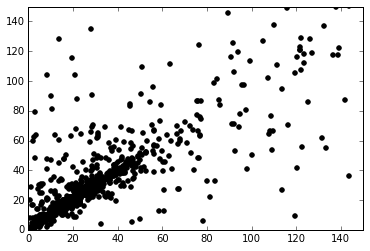

In [21]:
pred_y = cross_validation.cross_val_predict(gbr_opt,train_X,train_y,cv=10)
#pred_y = cross_validation.cross_val_predict?
plt.scatter(train_y, pred_y,  color='black')
plt.xlim((0,150))
plt.ylim ((0,150))

plt.show()

In [25]:
gbr_opt.feature_importances_

array([ 0.25940479,  0.03014434,  0.02341929,  0.0133148 ,  0.03103906,
        0.01922773,  0.02717154,  0.00979156,  0.05484876,  0.01897478,
        0.03230741,  0.06325135,  0.16707332,  0.05070555,  0.05057692,
        0.01528155,  0.01430774,  0.00724361,  0.0482879 ,  0.063628  ])

In [26]:
test_set = pd.read_csv(os.path.join('..','competition_data','test_set.csv'))

In [50]:
test_set.columns

Index([u'id', u'tube_assembly_id', u'supplier', u'quote_date', u'annual_usage',
       u'min_order_quantity', u'bracket_pricing', u'quantity'],
      dtype='object')

In [27]:
# Merge the tube.csv and bill of sale with train_set.csv to get the parameter
tubedf = pd.read_csv(os.path.join('..','competition_data','tube.csv'), index_col=0, header=0)
compdf = pd.read_csv(os.path.join('..','competition_data','components.csv'),index_col=0, header=0)
billdf = pd.read_csv(os.path.join('..','competition_data','bill_of_materials.csv'),index_col=0, header=0)

print tubedf.columns

Index([u'material_id', u'diameter', u'wall', u'length', u'num_bends',
       u'bend_radius', u'end_a_1x', u'end_a_2x', u'end_x_1x', u'end_x_2x',
       u'end_a', u'end_x', u'num_boss', u'num_bracket', u'other'],
      dtype='object')


In [28]:
comp1, quant1, comp2, quant2, comp3, quant3, mat_id = [], [], [], [], [], [], []

for tubeid in test_set.tube_assembly_id.values:
    comp_id1 = billdf.loc[tubeid]['component_id_1']
    #print comp_id1
    try:
        if not isinstance(comp_id1,str):
            comp1.append(np.nan)
        else:
            #print compdf.loc[comp_id1]['name']
            comp1.append(compdf.loc[comp_id1]['name'])
    except:
        print comp_id1
    comp_id2 = billdf.loc[tubeid]['component_id_2']
    if not isinstance(comp_id2,str):
        comp2.append(np.nan)
    else:
        comp2.append(compdf.loc[comp_id2]['name'])
    comp_id3 = billdf.loc[tubeid]['component_id_3']
    if not isinstance(comp_id3,str):
        comp3.append(np.nan)
    else:
        comp3.append(compdf.loc[comp_id3]['name'])
    if not np.isnan(billdf.loc[tubeid]['quantity_1']):
        quant1.append(billdf.loc[tubeid]['quantity_1'])
    else:
        quant1.append(0)
    if not np.isnan(billdf.loc[tubeid]['quantity_2']):
        quant2.append(billdf.loc[tubeid]['quantity_2'])
    else:
        quant2.append(0)
    if not np.isnan(billdf.loc[tubeid]['quantity_3']):
        quant3.append(billdf.loc[tubeid]['quantity_3'])
    else:
        quant3.append(0)
#    quant3.append(billdf.loc[tubeid]['quantity_3'])


In [29]:
matid, dia, wall, length, n_bends, bend_rad = [], [], [], [], [], []
for tubeid in test_set.tube_assembly_id.values:
    matid.append(tubedf.loc[tubeid]['material_id'])
    dia.append(tubedf.loc[tubeid]['diameter'])
    wall.append(tubedf.loc[tubeid]['wall'])
    length.append(tubedf.loc[tubeid]['length'])
    n_bends.append(tubedf.loc[tubeid]['num_bends'])
    bend_rad.append(tubedf.loc[tubeid]['bend_radius'])

In [30]:
end_a_2x, end_x_2x, end_a, end_x = [], [], [], []
for tubeid in test_set.tube_assembly_id.values:
    end_a_2x.append(tubedf.loc[tubeid]['end_a_2x'])
    end_x_2x.append(tubedf.loc[tubeid]['end_x_2x'])
    end_a.append(tubedf.loc[tubeid]['end_a'])
    end_x.append(tubedf.loc[tubeid]['end_x'])

In [31]:
comp1x, comp2x, comp3x, quant1x, quant2x, quant3x = map(np.array, [comp1, comp2, comp3, quant1, quant2, quant3])
matidx, diax, wallx, lengthx, n_bendsx, bend_radx = map(np.array, [matid, dia, wall, length, n_bends, bend_rad])
end_a_2xx, end_x_2xx, end_ax, end_xx = map(np.array, [end_a_2x, end_x_2x, end_a, end_x])

In [32]:
year, month, ofsetdate = [], [], []
for id1 in test_set.id:
    qdate = pd.to_datetime(test_set.iloc[id1-1]['quote_date'])
    year.append(qdate.year)
    month.append(qdate.month)
    ofsetdate.append( (qdate-pd.to_datetime('2010-12-31')).days)

In [33]:
testp = test_set.loc[:,['quantity']]
testp.insert(1,'component_id_1_name', comp1x,allow_duplicates=False)
testp.insert(2,'quantity_1', quant1x, allow_duplicates=False)
testp.insert(3,'component_id_2_name', comp1x,allow_duplicates=False)
testp.insert(4,'quantity_2', quant1x, allow_duplicates=False)
testp.insert(5,'component_id_3_name', comp1x,allow_duplicates=False)
testp.insert(6,'quantity_3', quant1x, allow_duplicates=False)
testp.insert(7,'material_id',matidx,  allow_duplicates=False)
testp.insert(8,'diameter', diax, allow_duplicates=False)
testp.insert(9,'wall', wallx, allow_duplicates=False)
testp.insert(10,'length', lengthx, allow_duplicates=False)
testp.insert(11,'num_bends',n_bendsx, allow_duplicates=False)
testp.insert(12,'bend_radius', bend_radx, allow_duplicates=False)
testp.insert(13,'end_a_2x', end_a_2xx, allow_duplicates=False)
testp.insert(14,'end_x_2x', end_x_2xx, allow_duplicates=False)
testp.insert(15,'end_a', end_ax, allow_duplicates=False)
testp.insert(16,'end_x', end_xx, allow_duplicates=False)
testp.insert(17,'year', year, allow_duplicates=False)
testp.insert(18,'month', month, allow_duplicates=False)
testp.insert(19,'day',ofsetdate, allow_duplicates=False)


In [34]:
testp1 = testp.copy()
for key,value in material_id_map.items():
    testp1.material_id[testp1.material_id==key] = value
testp1.material_id[testp1.material_id.isnull()] = 4

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
testp2 = testp1.copy()
for key,value in end_map.items():
    testp2.end_a[testp2.end_a==key] = value
    testp2.end_x[testp2.end_x==key] = value
testp2.end_a[testp2.end_a.isnull()] = 4
testp2.end_x[testp2.end_x.isnull()] = 4

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [36]:
testp3 = testp2.copy()
testp3.end_x_2x[testp3.end_x_2x=='N'] = 0
testp3.end_x_2x[testp3.end_x_2x=='Y'] = 1
testp3.end_a_2x[testp3.end_a_2x=='N'] = 0
testp3.end_a_2x[testp3.end_a_2x=='Y'] = 1

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyW

In [189]:
print lbl3_map

{nan: 0, 'ELBOW-90 DEG': 17, 'HEAD FLANGED': 25, 'ELBOW-90 DEGREE': 18, 'BLOCK-HYD': 6, 'NUT-SWIVEL': 28, 'FLANGE': 21, 'CONNECTOR': 8, 'ELBOW': 14, 'ELBOW-37 (DEG)': 15, 'CONNECTOR-WELD': 13, 'BLOCK': 5, 'CONNECTOR-ORFS': 10, 'ADAPTER-O SUPPL': 3, 'HEAD-FLANGED': 26, 'ADAPTER-O LINE': 2, 'FLANGE-ONE PIEC': 23, 'TEE-FLARED': 35, 'ELBOW-HYDRAULIC': 19, 'SLEEVE-FLARED': 32, 'ADAPTER': 1, 'SLEEVE-REDUCER': 34, 'CONNECTOR-BHD': 9, 'FLANGE-ONE PC': 22, 'BOSS': 7, 'NUT-ORFS': 27, 'FITTING': 20, 'CONNECTOR-SPL': 12, 'CONNECTOR-SEAL': 11, 'PLATE': 29, 'FLANGE-ONE PIECE': 24, 'SLEEVE': 31, 'TUBE': 36, 'TUBE AS.': 37, 'SLEEVE-ORFS': 33, 'PLUG-STOR': 30, 'ELBOW-90 (DEG)': 16, 'ADAPTER-OIL LIN': 4}


In [57]:
testp4 = testp3.copy()
k1 = lbl1_map.keys()
val = testp4.component_id_1_name.values
mask = [x not in k1 for x in val] 
#for i in range(len(testp4.component_id_1_name)):
#    if testp4.component_id_1_name[i] not in lbl1_map:
#        testp4.component_id_1_name[i] = 1
testp4.component_id_1_name[mask] = 1
k2 = lbl2_map.keys()
val = testp4.component_id_2_name.values
mask = [x not in k2 for x in val] 
testp4.component_id_2_name[mask] = 1
k3 = lbl3_map.keys()
val = testp4.component_id_3_name.values
mask = [x not in k3 for x in val] 
testp4.component_id_3_name[mask] = 1

#for i in range(len(testp4.component_id_2_name)):
#    if testp4.component_id_2_name[i] not in lbl2_map:
#        testp4.component_id_2_name[i] = 1
#for i in range(len(testp4.component_id_3_name)):
#    if testp4.component_id_3_name[i] not in lbl3_map:
#        testp4.component_id_3_name[i] = 1


/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:

for key,value in lbl1_map.items():
    testp4.component_id_1_name[testp4.component_id_1_name==key] = value
testp4.component_id_1_name[testp4.component_id_1_name.isnull()] = 0
for key,value in lbl2_map.items():
    testp4.component_id_2_name[testp4.component_id_2_name==key] = value
testp4.component_id_2_name[testp4.component_id_2_name.isnull()] = 0
for key,value in lbl3_map.items():
    testp4.component_id_3_name[testp4.component_id_3_name==key] = value
testp4.component_id_3_name[testp4.component_id_3_name.isnull()] = 0


/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

In [70]:
testp5 = testp4.copy()
k1 = d1.keys()
val = testp5.component_id_1_name.values
mask = [x not in k1 for x in val] 
testp5.component_id_1_name[mask] = 1
k2 = d2.keys()
val = testp5.component_id_2_name.values
mask = [x not in k2 for x in val] 
testp5.component_id_2_name[mask] = 1
k3 = d3.keys()
val = testp5.component_id_3_name.values
mask = [x not in k3 for x in val] 
testp5.component_id_3_name[mask] = 1

/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [71]:
#testp5 = testp4.copy()
k1 = material_id_map.values()
print k1
val = testp5.material_id.values
mask = [x not in k1 for x in val] 
testp5.material_id[mask] = 4

[4, 4, 4, 1, 4, 4, 4, 4, 3, 4, 2, 0, 5]


/usr/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
testp4.component_id_1_name.value_counts()

43    14579
41     5802
37     2038
1      1987
14     1675
42      848
30      551
48      452
49      365
9       297
11      269
34      229
21      184
31      155
22      104
47      100
28       75
16       62
13       56
10       41
29       36
38       36
39       35
24       32
23       30
32       24
45       24
7        21
25       18
2        13
18       13
51       12
44       11
4        11
15       10
35       10
12        8
46        5
20        4
17        3
8         3
40        2
36        2
33        2
3         1
dtype: int64

In [52]:
testp5.component_id_1_name.value_counts()

43    14579
41     5802
1      4108
37     2038
14     1675
42      848
30      551
49      365
11      269
dtype: int64

In [61]:
testp5.component_id_3_name.value_counts()

1     27822
11     1675
33      365
8       269
17      104
dtype: int64

In [72]:
testp5.material_id.value_counts()

0    16051
1     5728
2     2947
3     2750
5     1559
4     1200
dtype: int64

In [64]:
testp5[0:1]

,quantity,component_id_1_name,quantity_1,component_id_2_name,quantity_2,component_id_3_name,quantity_3,material_id,diameter,wall,length,num_bends,bend_radius,end_a_2x,end_x_2x,end_a,end_x,year,month,day
0,1,43,2,35,2,1,2,1,12.7,1.65,164,5,38.1,0,0,0,0,2013,6,905


In [65]:
for column in testp5.columns:
    print column
    print testp5[column].value_counts()

quantity
1       7018
5       3160
10      2992
2       2741
25      2523
50      2513
100     2348
250     2218
20      1289
6        828
3        507
4        264
15       253
8        137
12       135
30       135
9        128
40       113
7        103
19       102
24        51
16        50
35        49
75        42
60        39
70        35
55        31
80        31
18        26
36        22
        ... 
1034       1
305        1
225        1
39         1
65         1
78         1
71         1
829        1
110        1
206        1
160        1
41         1
46         1
297        1
59         1
205        1
550        1
74         1
51         1
67         1
83         1
99         1
1500       1
92         1
104        1
170        1
2500       1
155        1
165        1
44         1
dtype: int64
component_id_1_name
43    14579
41     5802
1      4108
37     2038
14     1675
42      848
30      551
49      365
11      269
dtype: int64
quantity_1
2    18629
1    10114
0     1453


In [73]:
test_X = testp5.as_matrix(testp5.columns)

In [74]:
test_y_pred = gbr_opt.predict(test_X)

In [75]:
test_y_pred


array([  62.44401327,   19.37398556,    7.29879101, ...,   10.31148402,
        239.04804792,  240.71592552])

In [80]:
test_y_pred[test_y_pred<0] = 0.1

In [81]:
test_y_pred_ser = pd.Series(data=test_y_pred,name='cost')
#pd.Series?

In [82]:
test_y_pred_ser.to_csv(os.path.join('..','competition_data','cost_predicted.csv'))